In [ ]:
import zipfile
import urllib.request
import os

# Step 1: Download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
output_path = 'ml-1m.zip'

if not os.path.exists('ml-1m'):
    urllib.request.urlretrieve(url, output_path)

    # Step 2: Extract
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall()

    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [ ]:
import pandas as pd

# Load users.dat
users = pd.read_csv('ml-1m/users.dat',
                    sep='::',
                    engine='python',
                    encoding='latin-1',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

# Load ratings.dat
ratings = pd.read_csv('ml-1m/ratings.dat',
                      sep='::',
                      engine='python',
                      encoding='latin-1',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Load movies.dat
movies = pd.read_csv('ml-1m/movies.dat',
                     sep='::',
                     engine='python',
                     encoding='latin-1',
                     names=['MovieID', 'Title', 'Genres'])

# Convert Timestamp
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Merge all into a single DataFrame for hybrid filtering
df = pd.merge(pd.merge(ratings, users), movies)

# Preview
print(df.head())


   UserID  MovieID  Rating           Timestamp Gender  Age  Occupation  \
0       1     1193       5 2000-12-31 22:12:40      F    1          10   
1       1      661       3 2000-12-31 22:35:09      F    1          10   
2       1      914       3 2000-12-31 22:32:48      F    1          10   
3       1     3408       4 2000-12-31 22:04:35      F    1          10   
4       1     2355       5 2001-01-06 23:38:11      F    1          10   

  Zip-code                                   Title  \
0    48067  One Flew Over the Cuckoo's Nest (1975)   
1    48067        James and the Giant Peach (1996)   
2    48067                     My Fair Lady (1964)   
3    48067                  Erin Brockovich (2000)   
4    48067                    Bug's Life, A (1998)   

                         Genres  
0                         Drama  
1  Animation|Children's|Musical  
2               Musical|Romance  
3                         Drama  
4   Animation|Children's|Comedy  


Dataset shape: (1000209, 10)
Unique users: 6040
Unique movies: 3706


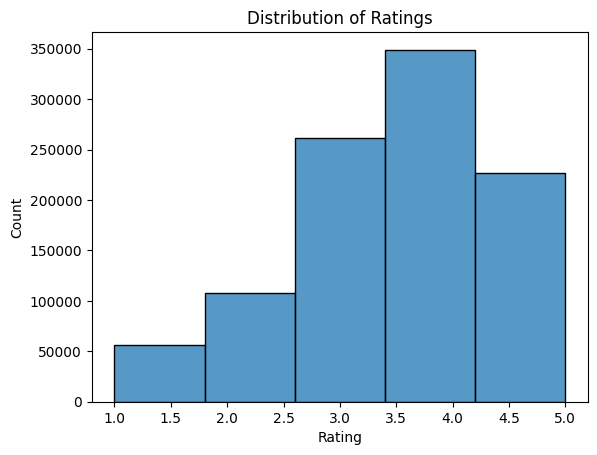


Top 10 Most Rated Movies:
Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: Rating, dtype: int64


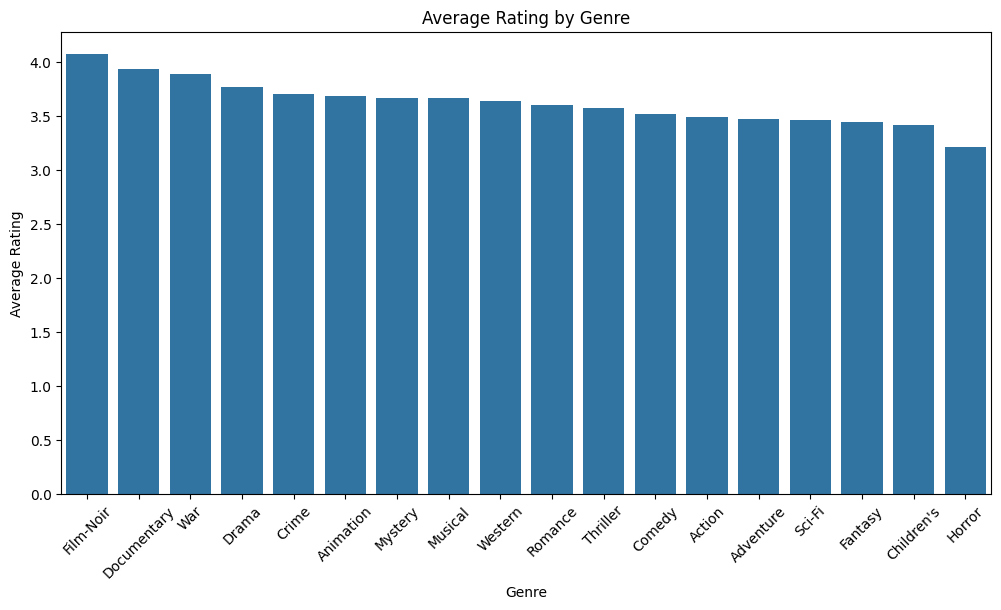

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
print("Dataset shape:", df.shape)
print("Unique users:", df['UserID'].nunique())
print("Unique movies:", df['MovieID'].nunique())

# Ratings distribution
sns.histplot(df['Rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Most rated movies
most_rated = df.groupby('Title')['Rating'].count().sort_values(ascending=False).head(10)
print("\nTop 10 Most Rated Movies:")
print(most_rated)

# Average rating by genre
df['Genres_split'] = df['Genres'].str.split('|')
genre_explode = df.explode('Genres_split')
avg_rating_by_genre = genre_explode.groupby('Genres_split')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_rating_by_genre.index, y=avg_rating_by_genre.values)
plt.xticks(rotation=45)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xlabel('Genre')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert genres into TF-IDF features
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

# Map movie IDs to index
movie_indices = pd.Series(movies.index, index=movies['MovieID'])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)


TF-IDF Matrix shape: (3883, 18)


In [ ]:
# Create user-item rating matrix
user_item_matrix = df.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Fill NaNs with 0 for SVD (or use surprise lib later)
user_item_matrix_filled = user_item_matrix.fillna(0)

print("User-Item Matrix shape:", user_item_matrix.shape)


User-Item Matrix shape: (6040, 3706)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# TF-IDF on genres
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

# Compute cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Movie index mapping
indices = pd.Series(movies.index, index=movies['Title'])

# Recommendation function
def content_based_recommendations(title, top_n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['Title'].iloc[movie_indices]

# Example usage
print("🎬 Content-Based Recommendations for 'Toy Story (1995)':")
print(content_based_recommendations('Toy Story (1995)'))


🎬 Content-Based Recommendations for 'Toy Story (1995)':
1050            Aladdin and the King of Thieves (1996)
2072                          American Tail, An (1986)
2073        American Tail: Fievel Goes West, An (1991)
2285                         Rugrats Movie, The (1998)
2286                              Bug's Life, A (1998)
3045                                Toy Story 2 (1999)
3542                             Saludos Amigos (1943)
3682                                Chicken Run (2000)
3685    Adventures of Rocky and Bullwinkle, The (2000)
12                                        Balto (1995)
Name: Title, dtype: object


In [ ]:
%pip install surprise

In [ ]:
%pip uninstall numpy -y
%pip install numpy==1.24.3

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
blosc2 3.5.

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
model = SVD()
model.fit(trainset)

# Evaluate
predictions = model.test(testset)
print("Collaborative Filtering RMSE:", accuracy.rmse(predictions))

# Recommend for a specific user
def svd_recommendations(user_id, n=10):
    movie_ids = df['MovieID'].unique()
    rated_movies = df[df['UserID'] == user_id]['MovieID']
    unrated_movies = [mid for mid in movie_ids if mid not in rated_movies.values]
    predictions = [(mid, model.predict(user_id, mid).est) for mid in unrated_movies]
    top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_movie_ids = [mid for mid, _ in top_predictions]
    return movies[movies['MovieID'].isin(top_movie_ids)]['Title'].values

# Example
print("🎯 Collaborative Recommendations for User 1:")
print(svd_recommendations(1))


RMSE: 0.8747
Collaborative Filtering RMSE: 0.8746817261848816
🎯 Collaborative Recommendations for User 1:
['Shawshank Redemption, The (1994)' 'Silence of the Lambs, The (1991)'
 'Sting, The (1973)' 'Great Escape, The (1963)' 'Good Will Hunting (1997)'
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'American History X (1998)' 'Sanjuro (1962)' 'Green Mile, The (1999)'
 'Inherit the Wind (1960)']
